In [1]:
import surprise
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from functools import partial

In [2]:
final_df = pd.read_csv("config_cycles.csv")

In [3]:
final_df

,program_name,config,cycles
0,raytrace,"4,64k,1m,16m",5162965136
1,raytrace,"4,32k,1m,16m",13815380707
2,raytrace,"4,32k,2m,32m",31009448393
3,raytrace,"4,64k,2m,32m",24088271698
4,swaptions,"4,64k,1m,32m",1527718090
5,swaptions,"4,32k,2m,32m",1708237934
6,swaptions,"4,64k,2m,32m",1524272911
7,swaptions,"8,32k,2m,32m",940791972
8,swaptions,"4,32k,1m,32m",1708237934
9,swaptions,"4,64k,1m,16m",1527718090


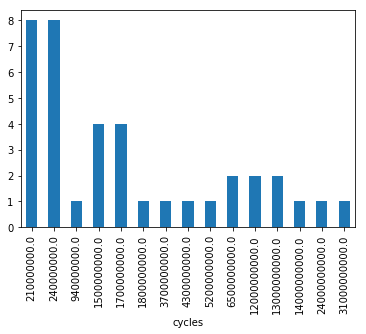

In [4]:
# Credit to Falken for rounding to significant digits logic: https://stackoverflow.com/a/48812729
z = final_df.cycles.apply(lambda i: float(f'{float(f"{i:.2g}"):g}'))
z.groupby(z).agg("count").plot.bar()

We can see some right skewness making a log transformation useful

In [5]:
log_scaled_df = final_df.copy()
log_scaled_df.cycles = np.log(log_scaled_df.cycles)
log_scaled_df

,program_name,config,cycles
0,raytrace,"4,64k,1m,16m",22.364777
1,raytrace,"4,32k,1m,16m",23.349048
2,raytrace,"4,32k,2m,32m",24.157558
3,raytrace,"4,64k,2m,32m",23.904991
4,swaptions,"4,64k,1m,32m",21.147041
5,swaptions,"4,32k,2m,32m",21.258728
6,swaptions,"4,64k,2m,32m",21.144783
7,swaptions,"8,32k,2m,32m",20.662233
8,swaptions,"4,32k,1m,32m",21.258728
9,swaptions,"4,64k,1m,16m",21.147041


In [6]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
cycles_scaled_min_max = min_max_scaler.fit_transform(log_scaled_df.cycles.values.reshape(-1,1))
min_max_log_df = log_scaled_df.copy()
min_max_log_df["cycles"] = cycles_scaled_min_max
min_max_log_df

,program_name,config,cycles
0,raytrace,"4,64k,1m,16m",0.641700
1,raytrace,"4,32k,1m,16m",0.838413
2,raytrace,"4,32k,2m,32m",1.000000
3,raytrace,"4,64k,2m,32m",0.949523
4,swaptions,"4,64k,1m,32m",0.398326
5,swaptions,"4,32k,2m,32m",0.420648
6,swaptions,"4,64k,2m,32m",0.397875
7,swaptions,"8,32k,2m,32m",0.301434
8,swaptions,"4,32k,1m,32m",0.420648
9,swaptions,"4,64k,1m,16m",0.398326


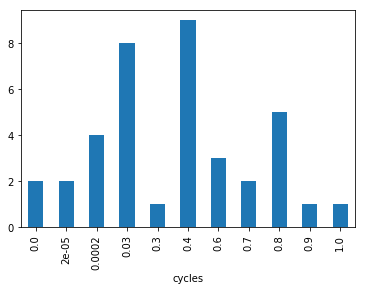

In [7]:
z2 = min_max_log_df.cycles.apply(lambda i: float(f'{float(f"{i:.1g}"):g}'))
z2.groupby(z2).agg("count").plot.bar()

In [8]:
algo = surprise.SVD()
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(min_max_log_df[min_max_log_df.program_name != 'fluidanimate'], reader)

In [9]:
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True, return_train_measures=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1872  0.1322  0.1487  0.3549  0.4269  0.2500  0.1186  
RMSE (trainset)   0.1372  0.1780  0.1558  0.1439  0.1573  0.1544  0.0140  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.18718316, 0.1321681 , 0.14874246, 0.35485096, 0.42687979]),
 'train_rmse': array([0.13721737, 0.17801656, 0.15576904, 0.14387376, 0.15732264]),
 'fit_time': (0.003095865249633789,
  0.003496885299682617,
  0.0023610591888427734,
  0.0023450851440429688,
  0.0018849372863769531),
 'test_time': (0.0001850128173828125,
  0.00013589859008789062,
  0.00016117095947265625,
  0.00015997886657714844,
  0.00010085105895996094)}

In [10]:
estimates = []
for possible_config in min_max_log_df.config.unique():
    est = algo.predict(uid="canneal", iid=possible_config).est
    estimates.append((possible_config, est))

estimates.sort(key=lambda x: x[1])

estimates

[('4,64k,1m,32m', 0.19653930331763095),
 ('8,32k,2m,16m', 0.22444264028677094),
 ('8,64k,2m,16m', 0.23080682551655124),
 ('8,32k,2m,32m', 0.259060048865912),
 ('4,32k,1m,16m', 0.33306053686747045),
 ('8,64k,2m,32m', 0.3472157030071465),
 ('4,64k,1m,16m', 0.36374100604796844),
 ('8,32k,1m,16m', 0.3640376008381326),
 ('4,64k,2m,16m', 0.36676142410095686),
 ('4,32k,2m,16m', 0.3952856535846484),
 ('8,64k,1m,32m', 0.39944706078209136),
 ('8,32k,1m,32m', 0.42648324535808013),
 ('4,32k,2m,32m', 0.4471485135534344),
 ('4,64k,2m,32m', 0.48744065418236426),
 ('4,32k,1m,32m', 0.5201999679984667),
 ('8,64k,1m,16m', 0.5256148683050437)]

In [11]:
min_max_log_df[min_max_log_df.program_name == "canneal"].sort_values("cycles")

,program_name,config,cycles
31,canneal,"4,64k,1m,32m",0.425663
29,canneal,"4,64k,1m,16m",0.573238
30,canneal,"4,32k,1m,16m",0.814702
34,canneal,"4,32k,1m,32m",0.814702
33,canneal,"4,64k,2m,32m",0.822679
32,canneal,"4,32k,2m,32m",0.826120


### Hyperparameter Tuning

Main metric of evaluation is RMSE

In [2]:
min_max_log_df = pd.read_csv("min_max_log_scaled.csv")
min_max_log_df

,program_name,config,cycles
0,raytrace,"4,64k,1m,16m",0.641700
1,raytrace,"4,32k,1m,16m",0.838413
2,raytrace,"4,32k,2m,32m",1.000000
3,raytrace,"4,64k,2m,32m",0.949523
4,swaptions,"4,64k,1m,32m",0.398326
5,swaptions,"4,32k,2m,32m",0.420648
6,swaptions,"4,64k,2m,32m",0.397875
7,swaptions,"8,32k,2m,32m",0.301434
8,swaptions,"4,32k,1m,32m",0.420648
9,swaptions,"4,64k,1m,16m",0.398326


In [8]:
param_grid = {'n_epochs': [10, 20, 50, 100], # 20 is default
              'n_factors': [5, 10, 50, 100, 150], # 100 is default
              'lr_bu': [5e-3, 1e-2, 5e-2, 1e-1], # 0.005
              'lr_bi': [5e-3, 1e-2, 5e-2, 1e-1], # 0.005
              'lr_pu': [5e-3, 1e-2, 5e-2, 1e-1], # 0.005
              'lr_qi': [5e-3, 1e-2, 5e-2, 1e-1], # 0.005
              'reg_pu': [1e-3, 1e-2, 2e-2, 1e-1], # 0.02
              'reg_qi':[1e-3, 1e-2, 2e-2, 1e-1], # 0.02
              'reg_bu': [1e-3, 1e-2, 2e-2, 1e-1], # 0.02
              'reg_bi': [1e-3, 1e-2, 2e-2, 1e-1], # 0.02
             }

In [9]:
gs = surprise.model_selection.GridSearchCV(surprise.SVD, param_grid, measures=['rmse'], cv=5, return_train_measures=True, n_jobs=-2)

In [10]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(min_max_log_df[min_max_log_df.program_name != 'fluidanimate'], reader)
gs.fit(data)

In [11]:
print(gs.best_params['rmse'])

{'n_epochs': 50, 'n_factors': 100, 'lr_bu': 0.1, 'lr_bi': 0.05, 'lr_pu': 0.01, 'lr_qi': 0.005, 'reg_pu': 0.02, 'reg_qi': 0.1, 'reg_bu': 0.001, 'reg_bi': 0.01}


In [15]:
#pd.set_option('display.max_colwidth', None)

In [16]:
pd.DataFrame.from_dict(gs.cv_results).sort_values("mean_test_rmse").iloc[:10,10:14]

,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse
910513,0.052131,0.017933,0.031252,0.001832
1146915,0.063854,0.036048,0.040140,0.009018
181617,0.064268,0.016695,0.084100,0.013309
1169728,0.064746,0.024205,0.007464,0.000829
1100310,0.064764,0.028421,0.019334,0.003359
835927,0.065398,0.014251,0.053882,0.011230
557275,0.065615,0.019236,0.075622,0.016403
508005,0.065616,0.019970,0.086348,0.010607
185528,0.065695,0.026349,0.081770,0.010310
1304963,0.065784,0.040470,0.003864,0.000545


In [17]:
pd.DataFrame.from_dict(gs.cv_results).sort_values("mean_test_rmse")["params"][:10]

910513         {'n_epochs': 50, 'n_factors': 100, 'lr_bu': 0.1, 'lr_bi': 0.05, 'lr_pu': 0.01, 'lr_qi': 0.005, 'reg_pu': 0.02, 'reg_qi': 0.1, 'reg_bu': 0.001, 'reg_bi': 0.01}
1146915    {'n_epochs': 100, 'n_factors': 50, 'lr_bu': 0.05, 'lr_bi': 0.005, 'lr_pu': 0.005, 'lr_qi': 0.005, 'reg_pu': 0.001, 'reg_qi': 0.02, 'reg_bu': 0.001, 'reg_bi': 0.1}
181617          {'n_epochs': 10, 'n_factors': 50, 'lr_bu': 0.1, 'lr_bi': 0.005, 'lr_pu': 0.01, 'lr_qi': 0.01, 'reg_pu': 0.01, 'reg_qi': 0.1, 'reg_bu': 0.001, 'reg_bi': 0.01}
1169728      {'n_epochs': 100, 'n_factors': 50, 'lr_bu': 0.1, 'lr_bi': 0.01, 'lr_pu': 0.05, 'lr_qi': 0.01, 'reg_pu': 0.01, 'reg_qi': 0.001, 'reg_bu': 0.001, 'reg_bi': 0.001}
1100310       {'n_epochs': 100, 'n_factors': 10, 'lr_bu': 0.1, 'lr_bi': 0.005, 'lr_pu': 0.05, 'lr_qi': 0.05, 'reg_pu': 0.001, 'reg_qi': 0.01, 'reg_bu': 0.01, 'reg_bi': 0.02}
835927          {'n_epochs': 50, 'n_factors': 50, 'lr_bu': 0.1, 'lr_bi': 0.005, 'lr_pu': 0.005, 'lr_qi': 0.01, 'reg_pu': 0.01, 're

We can see that the number of epochs can range from 10 to 100 and factors from 10 to 100. We can consider a lower epoch and factor range to avoid the possibility of overfitting. We can observe the a gap of 0.022 RMSE between the mean test and train RMSE for the best configuration of 50 epochs and 100 factors. for the rest of the parameters: lr_bu - 0.05 to 0.1, lr_bi - around 0.005, lr_pu around 0.05 and at 0.005, lr_qi around 0.05 and at 0.005, reg_pu around 0.02, reg_qi around 0.02, reg_bu around 0.01 and 0.005 (due to the 0.001 occuring) and reg_bi - 0.01 to 0.1

In [22]:
param_grid = {'n_epochs': [20, 30, 40, 50, 60, 70],
              'n_factors': [10, 20, 30, 50, 70], 
              'lr_bu': [0.05, 0.07, 0.1],
              'lr_bi': [0.005, 0.007, 0.01],
              'lr_pu': [0.005, 0.01, 0.03, 0.05],
              'lr_qi': [0.005, 0.01, 0.03, 0.05],
              'reg_pu': [0.01, 0.02, 0.05, 0.07],
              'reg_qi':[0.01, 0.02, 0.03, 0.07], 
              'reg_bu': [0.01, 0.02, 0.03, 0.005],
              'reg_bi': [0.01, 0.05, 0.1], 
             }

In [23]:
gs = surprise.model_selection.GridSearchCV(surprise.SVD, param_grid, measures=['rmse'], cv=5, return_train_measures=True, n_jobs=-2)
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(min_max_log_df[min_max_log_df.program_name != 'fluidanimate'], reader)
gs.fit(data)

In [28]:
print(gs.best_params['rmse'])

{'n_epochs': 30, 'n_factors': 50, 'lr_bu': 0.07, 'lr_bi': 0.005, 'lr_pu': 0.01, 'lr_qi': 0.005, 'reg_pu': 0.02, 'reg_qi': 0.03, 'reg_bu': 0.02, 'reg_bi': 0.05}


In [29]:
pd.DataFrame.from_dict(gs.cv_results).sort_values("mean_test_rmse").iloc[:10,10:14]

,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse
231244,0.060969,0.022418,0.063745,0.007158
403235,0.061633,0.018225,0.055004,0.009603
83926,0.062560,0.022454,0.067908,0.012579
406640,0.063789,0.026813,0.046916,0.009189
114479,0.064117,0.005179,0.070358,0.009758
247420,0.064184,0.019184,0.045280,0.006121
538093,0.064574,0.013808,0.027516,0.003983
246790,0.064800,0.026500,0.052346,0.003023
532010,0.065241,0.022665,0.028399,0.003817
68527,0.065339,0.031987,0.071109,0.008186


In [30]:
pd.DataFrame.from_dict(gs.cv_results).sort_values("mean_test_rmse")["params"][:10]

231244    {'n_epochs': 30, 'n_factors': 50, 'lr_bu': 0.07, 'lr_bi': 0.005, 'lr_pu': 0.01, 'lr_qi': 0.005, 'reg_pu': 0.02, 'reg_qi': 0.03, 'reg_bu': 0.02, 'reg_bi': 0.05}
403235     {'n_epochs': 40, 'n_factors': 70, 'lr_bu': 0.07, 'lr_bi': 0.01, 'lr_pu': 0.01, 'lr_qi': 0.005, 'reg_pu': 0.01, 'reg_qi': 0.03, 'reg_bu': 0.005, 'reg_bi': 0.1}
83926     {'n_epochs': 20, 'n_factors': 50, 'lr_bu': 0.05, 'lr_bi': 0.005, 'lr_pu': 0.01, 'lr_qi': 0.01, 'reg_pu': 0.01, 'reg_qi': 0.02, 'reg_bu': 0.005, 'reg_bi': 0.05}
406640       {'n_epochs': 40, 'n_factors': 70, 'lr_bu': 0.1, 'lr_bi': 0.005, 'lr_pu': 0.01, 'lr_qi': 0.01, 'reg_pu': 0.07, 'reg_qi': 0.03, 'reg_bu': 0.03, 'reg_bi': 0.1}
114479    {'n_epochs': 20, 'n_factors': 70, 'lr_bu': 0.05, 'lr_bi': 0.007, 'lr_pu': 0.01, 'lr_qi': 0.005, 'reg_pu': 0.01, 'reg_qi': 0.07, 'reg_bu': 0.005, 'reg_bi': 0.1}
247420      {'n_epochs': 30, 'n_factors': 50, 'lr_bu': 0.1, 'lr_bi': 0.01, 'lr_pu': 0.03, 'lr_qi': 0.005, 'reg_pu': 0.05, 'reg_qi': 0.03, 'reg_bu': 0.

We can still observe low mean test RMSE scores and small differences between the mean test and train RMSE scores only with a large number of factors from 50 to 70. Due to the large factor size (which exceeds the number of items and users in the training set) and there is no significant improvement in mean test RMSE over a model with a consistent learning rate and regularization value for all parameters, the SVD model with bias without per-parameter learning rate and regularization, i.e., a model having lr\_all, reg\_all, seems to be the better choice.